In [4]:
import keras
import numpy as np
from scipy import misc


In [71]:
import os

directory = '/home/dlrc/Desktop/training_data'
def img_paths(directory):
    return [os.path.join(root, f) for root, _, files in os.walk(directory)
            for f in files if f != "target.png"]

paths = img_paths(directory)

def func(x):
  x = x.split("/")
  return "_".join([x[-3], x[-2]])

classes = [func(x) for x in paths]
classes

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
classes_encoded = le.fit_transform(list(classes))
classes_encoded

array([  3,   3,   3, ..., 299, 299, 299])

In [72]:
import cv2
from tqdm import tqdm
images = []
for img_path in tqdm(paths):
  img = misc.imread(img_path, mode='RGB')
  images.append(img)
images = np.asarray(images)

100%|██████████| 21043/21043 [00:07<00:00, 2796.57it/s]


In [73]:
#Shuffle images
import random
XY = list(zip(images,classes_encoded))
random.shuffle(XY)


In [74]:
'''Train a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for mode details).
[1] "Dimensionality Reduction by Learning an Invariant Mapping"
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Conv2D, Flatten
from keras.optimizers import RMSprop, Adam
from keras import backend as K
import random
from tqdm import tqdm

num_classes = 10


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_pairs(x, y, digit_indices, classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in classes]) - 1
    num_classes = len(classes)
    for d in tqdm(classes):
        for i in tqdm(range(n)):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    print(pairs)
    return np.array(pairs), np.array(labels)

  

def create_test_pairs(x, y, digit_indices, classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in classes]) - 1
    num_classes = len(classes)
    for i, y1 in enumerate(y):
      for j,y2 in enumerate(y):
        pairs += [[x[i], x[j]]]
        labels += [1 if y1==y2 else 0]
    return labels
  
    return np.array(pairs), np.array(labels)


def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Conv2D(32,3, 2, activation='relu', input_shape=(64,64,3)))
    seq.add(Dropout(0.1))
    seq.add(Conv2D(8,3, 3,activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    return seq


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
  

X = np.asarray([x for x,y in XY])
Y = np.asarray([y for x,y in XY])
  
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = (X[:-200], Y[:-200]), (X[-200:], Y[-200:])
x_train = x_train
x_test = x_test
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_dim = (64,64,3)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

classes = np.unique(Y)
classes_dict_train = {}
classes_dict_test = {}
for i,y in enumerate(y_train):
    l = classes_dict_train.get(y, [])
    l.append(i)
    classes_dict_train[y] = l

# create training+test positive and negative pairs
tr_pairs, tr_y = create_pairs(x_train, y_train, classes_dict_train, classes)
for i,y in enumerate(y_test):
    l = classes_dict_test.get(y, [])
    l.append(i)
    classes_dict_test[y] = l
    
classes = np.unique(y_test)    
te_pairs, te_y = create_test_pairs(x_test, y_test, classes_dict_test, classes)



  0%|          | 0/37 [00:00<?, ?it/s]

(20843, 64, 64, 3) (20843,)
(200, 64, 64, 3) (200,)



  0%|          | 0/37 [00:00<?, ?it/s]


  0%|          | 0/37 [00:00<?, ?it/s]


  0%|          | 0/37 [00:00<?, ?it/s]


100%|██████████| 310/310 [00:01<00:00, 180.82it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


ValueError: too many values to unpack (expected 2)

In [ ]:
print(y_train)

In [75]:
  

def create_test_pairs(x, y, digit_indices, classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in classes]) - 1
    num_classes = len(classes)
    for i, y1 in enumerate(y):
      for j,y2 in enumerate(y):
        pairs += [[x[i], x[j]]]
        labels += [1 if y1==y2 else 0]
  
    return np.array(pairs), np.array(labels)

  
# create training+test positive and negative pairs
tr_pairs, tr_y = create_pairs(x_train, y_train, classes_dict_train, classes)
for i,y in enumerate(y_test):
    l = classes_dict_test.get(y, [])
    l.append(i)
    classes_dict_test[y] = l
    
classes = np.unique(y_test)    
te_pairs, te_y = create_test_pairs(x_test, y_test, classes_dict_test, classes)


  0%|          | 0/37 [00:00<?, ?it/s]


100%|██████████| 136/136 [00:00<00:00, 207.55it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [76]:
te_pairs = te_pairs[:4000]
te_y = te_y[:4000]

In [ ]:
EPOCHS = 2000
BATCH_SIZE = 32

from keras.preprocessing import image
keras_generator = image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=True,
    zca_epsilon=1e-6,
    rotation_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.5,
    zoom_range=0.5,
    channel_shift_range=0.3,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=True,
    preprocessing_function=None,
    data_format=K.image_data_format())


#keras_generator.fit(x_train)

# network definition
base_network = create_base_network(input_dim)

input_a = Input(input_dim)
input_b = Input(input_dim)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

# callbacks
import os
filepath = "/home/dlrc/Desktop/siamese3/"
os.makedirs(filepath, exist_ok=True)
form = "checkpoint.{epoch:02d}.hdf5"

filepath_tensorboard = "/home/dlrc/Desktop/siamese3/logs"
os.makedirs(filepath_tensorboard, exist_ok=True)


checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath + form, verbose=0, 
                                                      save_best_only=False, save_weights_only=False, 
                                                      mode='auto', period=10)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=filepath_tensorboard, 
                                                   histogram_freq=0, batch_size=32, write_graph=True,
                            write_grads=False, write_images=False, embeddings_freq=0, 
                                                   embeddings_layer_names=None, embeddings_metadata=None)

gen1 = keras_generator.flow(tr_pairs[:, 0], tr_y, batch_size=BATCH_SIZE, shuffle=False)
gen2 = keras_generator.flow(tr_pairs[:, 1], tr_y, batch_size=BATCH_SIZE, shuffle=False)

def generator():
  while True:
    x1, tr_y = next(gen1)
    x2, tr_y = next(gen2)
    yield [x1,x2], tr_y

model.fit_generator(generator(),steps_per_epoch=30000,
          epochs=EPOCHS,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y), callbacks=[checkpoint_callback, tensorboard_callback])


# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

/home/dlrc/anaconda2/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 2), activation="relu", input_shape=(64, 64, 3...)`
/home/dlrc/anaconda2/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`


Epoch 1/2000


/home/dlrc/anaconda2/envs/ml/lib/python3.6/site-packages/keras/preprocessing/image.py:525: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 5298/30000 [====>.........................] - ETA: 1298s - loss: 0.2312 - accuracy: 0.6197

[[ 15.26025391]]


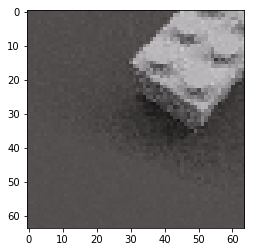

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline

pred = model.predict([np.expand_dims(images[10], axis=0), np.expand_dims(images[11], axis=0)])
print(pred)

plt.imshow(images[11])


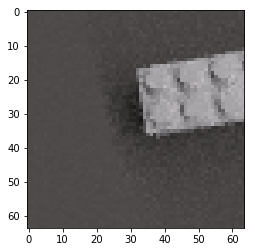

In [59]:
plt.imshow(images[10])